# What's here:

- read out top logits from Hooked Transformer (while steering) -- trying to get consistent results! and understand the hooks better!
Continuation of LetsDriftGemma2_Hooked_tutorials.ipynb

ENV: lets_drift_env_V1


# Setup
Conda Env == lets_drift_env_V1 
(Which is a clone of arena_env1_1_1c)

## Imports for Gemma Model

In [1]:
import torch as t


In [2]:
device = t.device('mps' if t.backends.mps.is_available() else 'cuda' if t.cuda.is_available() else 'cpu')


In [1]:
from huggingface_hub import login
login()  # This will prompt for your HuggingFace token in a text box


starts with a j..jeje .. f_JTQGGDeycTxPCozthrzqWQhmLpOkaVKXRq

In [4]:
from sae_lens import (
    SAE,
    ActivationsStore,
    HookedSAETransformer,
    LanguageModelSAERunnerConfig,
    SAEConfig,
    SAETrainingRunner,
    upload_saes_to_huggingface,
)
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
from transformer_lens import ActivationCache, HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
# from transformer_lens import HookedTransformer
from sae_lens import SAE, HookedSAETransformer
import pandas as pd

In [5]:
# for Neuronpedia
from IPython.display import HTML, IFrame, clear_output, display

In [6]:
# for steering impln
from rich import print as rprint
from rich.table import Table
from tqdm.auto import tqdm
from functools import partial
from jaxtyping import Float
from torch import Tensor

import torch.nn.functional as F

# Plot line chart of latent activations
import plotly.express as px

# instantiate an object to hold activations from a dataset for finding max activation of latent
from sae_lens import ActivationsStore


# load hooked model -- from Arena 3 Chpt 1.3.2

full list of models in TransformerLens:
https://transformerlensorg.github.io/TransformerLens/generated/model_properties_table.html


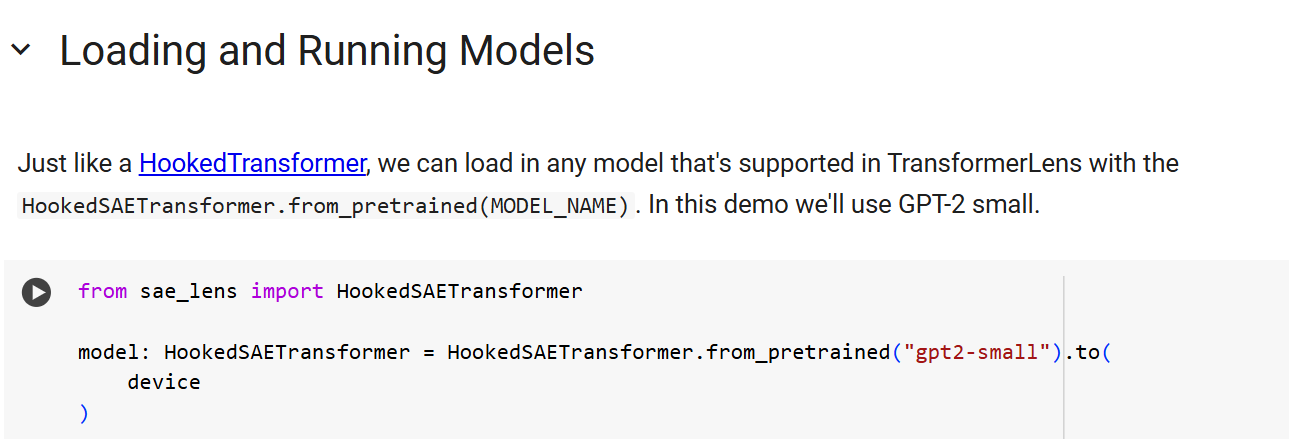

From: https://colab.research.google.com/github/jbloomAus/SAELens/blob/main/tutorials/Hooked_SAE_Transformer_Demo.ipynb

how to configure and import HookedSAETransformer:
https://github.com/jbloomAus/SAELens/blob/main/tutorials/tutorial_2_0.ipynb


In [7]:
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
"""
df = pd.DataFrame.from_records(
    {k: v.__dict__ for k, v in get_pretrained_saes_directory().items()}
).T
df.drop(
    columns=[
        "expected_var_explained",
        "expected_l0",
        "config_overrides",
        "conversion_func",
    ],
    inplace=True,
)
df  # Each row is a "release" which has multiple SAEs which may have different configs / match different hook points in a model"""

'\ndf = pd.DataFrame.from_records(\n    {k: v.__dict__ for k, v in get_pretrained_saes_directory().items()}\n).T\ndf.drop(\n    columns=[\n        "expected_var_explained",\n        "expected_l0",\n        "config_overrides",\n        "conversion_func",\n    ],\n    inplace=True,\n)\ndf  # Each row is a "release" which has multiple SAEs which may have different configs / match different hook points in a model'

Much better way to see all the available Scopes, including methods to import them to your code are here!!
https://www.neuronpedia.org/gemma-scope#browse

### Import Gemma2 as hooked model incld SAE

In [8]:

gemma_2_2b = HookedSAETransformer.from_pretrained("gemma-2-2b", device=device)

gemmascope_sae_release = "gemma-scope-2b-pt-res-canonical"
gemmascope_sae_id = "layer_20/width_16k/canonical"

gemma_2_2b_sae = SAE.from_pretrained(gemmascope_sae_release, gemmascope_sae_id, device=str(device))[0]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


### Gemma 2 - 2b implementation and then steering implementation from Arena3- 
**Note: had to UPGRADE SAE-Lens version. Apparently, SAEvis and SAEDashboard are not compatible. so they have been kicked from the imports**

#### display gemmaScope dashboard using Neuropedia and custom display_dashboard function

In [9]:
def display_dashboard(
    sae_release="gpt2-small-res-jb",
    sae_id="blocks.7.hook_resid_pre",
    latent_idx=0,
    width=800,
    height=600,
):
    release = get_pretrained_saes_directory()[sae_release]
    neuronpedia_id = release.neuronpedia_id[sae_id]

    url = f"https://neuronpedia.org/{neuronpedia_id}/{latent_idx}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

    print(url)
    display(IFrame(url, width=width, height=height))

#### CONFIG: Latent_idx and ENA_DEBUG_PRINT

In [10]:
ENA_DEBUG_PRINT = True

latent_idx = 12082

display_dashboard(sae_release=gemmascope_sae_release, sae_id=gemmascope_sae_id, latent_idx=latent_idx)

https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/12082?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


# Steering Hook

In [11]:
#from solutions.py part of part32_interp_with_saes because solution in Streamlit page isnt commplete - the steering_hook solution was misssing?
def steering_hook(
    activations: Float[Tensor, "batch pos d_in"],
    hook: HookPoint,
    sae: SAE,
    latent_idx: int,
    steering_coefficient: float,
) -> Tensor:
    """
    Steers the model by returning a modified activations tensor, with some multiple of the steering vector added to all
    sequence positions.
    """
    return activations + steering_coefficient * sae.W_dec[latent_idx]


## Config: GENERATE_KWARGS, manual seed

In [12]:
GENERATE_KWARGS = dict(temperature=0.5, freq_penalty=2.0, verbose=False)#(temperature=0.5, freq_penalty=2.0, verbose=False)
t.manual_seed(42)


Note that we can choose the value of steering_coefficient based on the maximum activation of the latent we're steering on (it's usually wise to choose quite close to the max activation, but not so far above that you steer the model far out of distribution - however this varies from latent to latent, e.g. in the case of this particular latent we'll find it still produces coherent output quite far above the max activation value). If we didn't have neuronpedia then we couldn't do this, and we'd be better off measuring the max activation over some suitably large dataset to guide what value to choose for our steering coefficient.



In [13]:
def display_dashboard(
    sae_release="gpt2-small-res-jb",  # The SAE model release name
    sae_id="blocks.7.hook_resid_pre",  # The specific hook point/layer
    latent_idx=0,                      # The feature number you want to inspect
    width=800,
    height=600,
):
    # Get the release info from the pretrained SAEs directory
    release = get_pretrained_saes_directory()[sae_release]
    # Get the Neuronpedia ID for this specific SAE configuration
    neuronpedia_id = release.neuronpedia_id[sae_id]

    # Construct the Neuronpedia URL with embed parameters
    url = f"https://neuronpedia.org/{neuronpedia_id}/{latent_idx}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

    print(url)
    # Display the dashboard in an iframe
    display(IFrame(url, width=width, height=height))
print(latent_idx)
# Example usage:
#latent_idx = 3997  # The feature number you want to inspect
display_dashboard(
    sae_release=gemmascope_sae_release,
    sae_id=gemmascope_sae_id, 
    latent_idx=latent_idx
)

12082
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/12082?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300



# generate with steering and cache
--> to get the activations at the hookpoint, even when generating with steering (fingers crossed)

In [14]:
def generate_with_steering_and_cache(
    model: HookedSAETransformer,
    sae: SAE,
    prompt: str,
    latent_idx: int,
    steering_coefficient: float = 1.0,
    max_new_tokens: int = 50,
):
    """
    Generates text with steering and returns both the output text and activation caches.
    Returns a tuple of (generated_text, list_of_caches) where list_of_caches contains
    the activation cache for each generation step.
    """
    _steering_hook = partial(
        steering_hook,
        sae=sae,
        latent_idx=latent_idx,
        steering_coefficient=steering_coefficient,
    )
    
    generated_tokens = []
    all_caches = []
    
    # Start with the prompt
    tokens = model.to_tokens(prompt)
    
    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, _steering_hook)]):
        for i in range(max_new_tokens):
            # Run model with cache for current sequence
            logits, cache = model.run_with_cache(tokens)
            all_caches.append(cache)
            
            # Get next token using the same generation parameters
            next_token = model.generate_next_token(
                tokens,
                temperature=GENERATE_KWARGS['temperature'],
                freq_penalty=GENERATE_KWARGS['freq_penalty']
            )
            
            # Add token to sequence
            tokens = t.cat([tokens, next_token], dim=-1)
            generated_tokens.append(next_token)
            
            # Optional: check for end of text token
            if next_token.item() == model.end_token_id:
                break
    
    # Convert tokens to text
    output_text = model.to_string(tokens)
    
    return output_text, all_caches




In [15]:
def generate_with_steering_and_cache(
    model: HookedSAETransformer,
    sae: SAE,
    prompt: str,
    latent_idx: int,
    steering_coefficient: float = 1.0,
    max_new_tokens: int = 50,
):
    """
    Generates text with steering and returns both the output text and activation caches.
    Returns a tuple of (generated_text, list_of_caches).
    """
    _steering_hook = partial(
        steering_hook,
        sae=sae,
        latent_idx=latent_idx,
        steering_coefficient=steering_coefficient,
    )
    
    generated_tokens = []
    all_caches = []
    
    # Start with the prompt
    tokens = model.to_tokens(prompt)
    
    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, _steering_hook)]):
        for i in range(max_new_tokens):
            # Run model with cache for current sequence
            logits, cache = model.run_with_cache(tokens)
            all_caches.append(cache)
            
            # Get next token using logits from the last position
            last_token_logits = logits[0, -1, :]
            
            # Apply temperature
            if GENERATE_KWARGS['temperature'] > 0:
                last_token_logits = last_token_logits / GENERATE_KWARGS['temperature']
            
            # Apply frequency penalty if specified
            if GENERATE_KWARGS.get('freq_penalty', 0) > 0:
                # Count token frequencies
                unique_tokens, counts = t.unique(tokens, return_counts=True)
                freq_penalty = t.zeros_like(last_token_logits)
                freq_penalty[unique_tokens] = counts.float() * GENERATE_KWARGS['freq_penalty']
                last_token_logits = last_token_logits - freq_penalty
            
            # Sample from the distribution
            probs = F.softmax(last_token_logits, dim=-1)
            next_token = t.multinomial(probs, num_samples=1)
            
            # Add token to sequence
            tokens = t.cat([tokens, next_token.unsqueeze(0)], dim=-1)
            generated_tokens.append(next_token)
            
            # Stop if we've generated max_new_tokens OR hit an EOS token
            if (i >= max_new_tokens - 1) or (next_token.item() == model.tokenizer.eos_token_id):
                break
    
    # Convert tokens to text
    output_text = model.to_string(tokens[0])  # Note: using tokens[0] to get the first batch
    
    return output_text, all_caches

In [16]:

# Function to analyze latents at each generation step
def analyze_generation_latents(caches, sae, top_k=10):
    """
    Analyzes the top latents for each generation step.
    """
    all_top_latents = []
    
    for cache in caches:
        # Get activations at the SAE hook point
        activations = cache[sae.cfg.hook_name]
        
        # Get last token's activations
        last_token_acts = activations[:, -1, :]
        
        # Get SAE activations
        latents = sae.encode(last_token_acts)
        
        # Get top k latents
        top_k_values, top_k_indices = t.topk(latents[0], k=top_k)
        
        # Store results
        all_top_latents.append(list(zip(top_k_indices.tolist(), top_k_values.tolist())))
    
    return all_top_latents


In [17]:
"""# Example usage:
prompt = "When I look at myself in the mirror, I see"
output_text, caches = generate_with_steering_and_cache(
    gemma_2_2b,
    gemma_2_2b_sae,
    prompt,
    latent_idx,
    steering_coefficient=240.0
)"""

'# Example usage:\nprompt = "When I look at myself in the mirror, I see"\noutput_text, caches = generate_with_steering_and_cache(\n    gemma_2_2b,\n    gemma_2_2b_sae,\n    prompt,\n    latent_idx,\n    steering_coefficient=240.0\n)'

In [18]:
"""print(output_text)"""

'print(output_text)'

## increase steering coefficient 2 times & only read out final latents (on last pass)

In [19]:
prompt = "When I look at myself in the mirror, I see"

#no_steering_output = gemma_2_2b.generate(prompt, max_new_tokens=50, **GENERATE_KWARGS)
no_steering_output, caches = generate_with_steering_and_cache(
    gemma_2_2b,
    gemma_2_2b_sae,
    prompt,
    latent_idx,
    steering_coefficient=1 # 1 should equal no steering?
)
final_latents = analyze_generation_latents([caches[-1]], gemma_2_2b_sae)[0][:10]
final_latents_cpu = [(idx, float(val)) for idx, val in final_latents]
    
table = Table(show_header=False, show_lines=True, title="Steering Output")
table.add_row("Normal", no_steering_output, f"Top 10: {final_latents_cpu}")
print("Cache shapes:")
for i, cache in enumerate(caches):
    print(f"Cache {i} shape:", {k: v.shape for k,v in cache.items()})
del caches
t.cuda.empty_cache()  # Clear CUDA cache

for i in tqdm(range(3), "Generating steered examples..."):
    # Generate steered text and get caches
    output_text, caches = generate_with_steering_and_cache(
        gemma_2_2b,
        gemma_2_2b_sae,
        prompt,
        latent_idx,
        steering_coefficient=240.0
    )
    
    # Get top latents from final step only and move to CPU
    final_latents = analyze_generation_latents([caches[-1]], gemma_2_2b_sae)[0][:10]
    final_latents_cpu = [(idx, float(val)) for idx, val in final_latents]
    
    # Add to table
    table.add_row(
        f"Steered #{i}",
        output_text.replace("\n", "↵"),
        f"Top 10: {final_latents_cpu}"
    )
    
    # Clear memory
    del caches
    t.cuda.empty_cache()  # Clear CUDA cache
    
rprint(table)

Cache shapes:
Cache 0 shape: {'hook_embed': torch.Size([1, 12, 2304]), 'blocks.0.hook_resid_pre': torch.Size([1, 12, 2304]), 'blocks.0.ln1.hook_scale': torch.Size([1, 12, 1]), 'blocks.0.ln1.hook_normalized': torch.Size([1, 12, 2304]), 'blocks.0.attn.hook_q': torch.Size([1, 12, 8, 256]), 'blocks.0.attn.hook_k': torch.Size([1, 12, 4, 256]), 'blocks.0.attn.hook_v': torch.Size([1, 12, 4, 256]), 'blocks.0.attn.hook_rot_q': torch.Size([1, 12, 8, 256]), 'blocks.0.attn.hook_rot_k': torch.Size([1, 12, 4, 256]), 'blocks.0.attn.hook_attn_scores': torch.Size([1, 8, 12, 12]), 'blocks.0.attn.hook_pattern': torch.Size([1, 8, 12, 12]), 'blocks.0.attn.hook_z': torch.Size([1, 12, 8, 256]), 'blocks.0.ln1_post.hook_scale': torch.Size([1, 12, 1]), 'blocks.0.ln1_post.hook_normalized': torch.Size([1, 12, 2304]), 'blocks.0.hook_attn_out': torch.Size([1, 12, 2304]), 'blocks.0.hook_resid_mid': torch.Size([1, 12, 2304]), 'blocks.0.ln2.hook_scale': torch.Size([1, 12, 1]), 'blocks.0.ln2.hook_normalized': torch.Siz

Generating steered examples...:   0%|          | 0/3 [00:00<?, ?it/s]

                                                  Steering Output                                                  
┌────────────┬─────────────────────────────────────────────────┬──────────────────────────────────────────────────┐
│ Normal     │ <bos>When I look at myself in the mirror, I see │ Top 10: [(12267, 59.735076904296875), (11612,    │
│            │ a woman who is strong and courageous.           │ 55.239166259765625), (14113, 49.22991943359375), │
│            │                                                 │ (12748, 44.49790573120117), (13108,              │
│            │ I have faced my fears and conquered them.       │ 40.02205276489258), (889, 31.769445419311523),   │
│            │                                                 │ (11133, 31.45663070678711), (13762,              │
│            │ I am not afraid of what people think of me      │ 29.016048431396484), (6336, 25.42552947998047),  │
│            │ anymore.                                        │ (8684, 22.775421142578125)]                      │
│            │                                                 │                                                  │
│            │ I know that I am loved by God and that He will  │                                                  │
│            │ never leave me or forsake me                    │                                                  │
├────────────┼─────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ Steered #0 │ <bos>When I look at myself in the mirror, I see │ Top 10: [(12082, 222.40695190429688), (1182,     │
│            │ a dog.↵↵I’s not just that my tail is constantly │ 114.92020416259766), (11133,                     │
│            │ wagging, or that my nose is always sniffing     │ 49.550411224365234), (3090, 45.822853088378906), │
│            │ around for treats. It’s that I am very often    │ (10379, 35.25349426269531), (6631,               │
│            │ looking at things from a dog-friendly           │ 32.43061828613281), (2468, 31.126670837402344),  │
│            │ perspective.↵↵Like when you                     │ (13253, 29.244342803955078), (14699,             │
│            │                                                 │ 28.672515869140625), (11135,                     │
│            │                                                 │ 27.232378005981445)]                             │
├────────────┼─────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ Steered #1 │ <bos>When I look at myself in the mirror, I see │ Top 10: [(12082, 217.26593017578125), (6027,     │
│            │ a little bit of my dad. He was a handsome man,  │ 92.2920150756836), (7116, 45.737545013427734),   │
│            │ and I’m not. But his eyes are my eyes, and his  │ (14113, 44.85353469848633), (15300,              │
│            │ nose is my nose.↵↵My father was always around   │ 43.8569221496582), (11133, 35.675392150878906),  │
│            │ when we were young – he was always there for us │ (13108, 35.41129684448242), (15605,              │
│            │                                                 │ 34.747467041015625), (889, 34.054779052734375),  │
│            │                                                 │ (11612, 31.85892677307129)]                      │
├────────────┼─────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ Steered #2 │ <bos>When I look at myself in the mirror, I see │ Top 10: [(12082, 215.76300048828125), (4551,     │
│            │ a woman who is 100% happy with her life and all │ 79.32356262207031), (10252, 69.07096099853516),  │
│            │ the things that she has going on for her.↵↵I    │ (15596, 68.7468032836914), (9775,                │
│            │ have a beautiful house, a wonderful dog, I am   │ 59.785552978515625), (8744, 49.97358703613281),  │
│            │ doing work that is rewarding and exciting

https://www.neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/11133

Temperature 0, freq penalty 0, random seed 42:
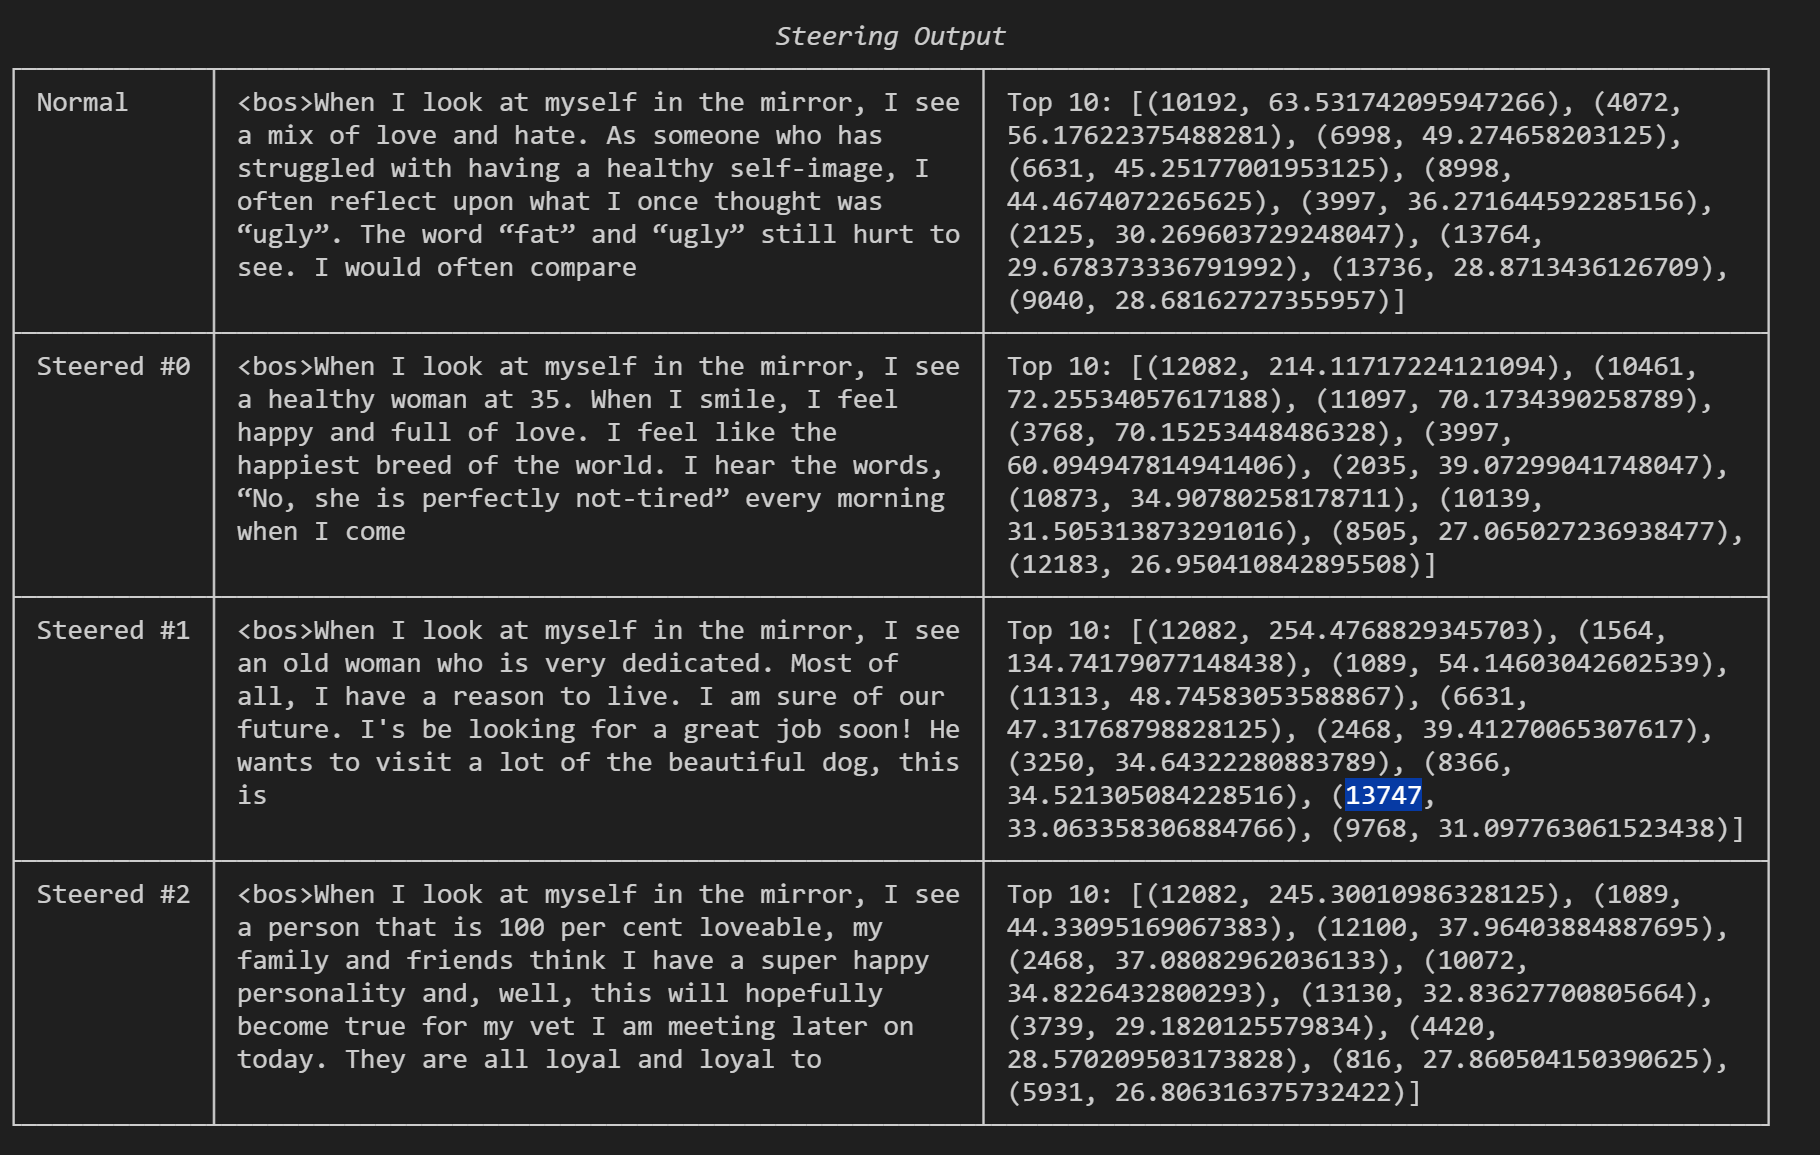

# Try3: Using 1.3.2, section 1, "Running SAEs" to modify the code
From the turotial:

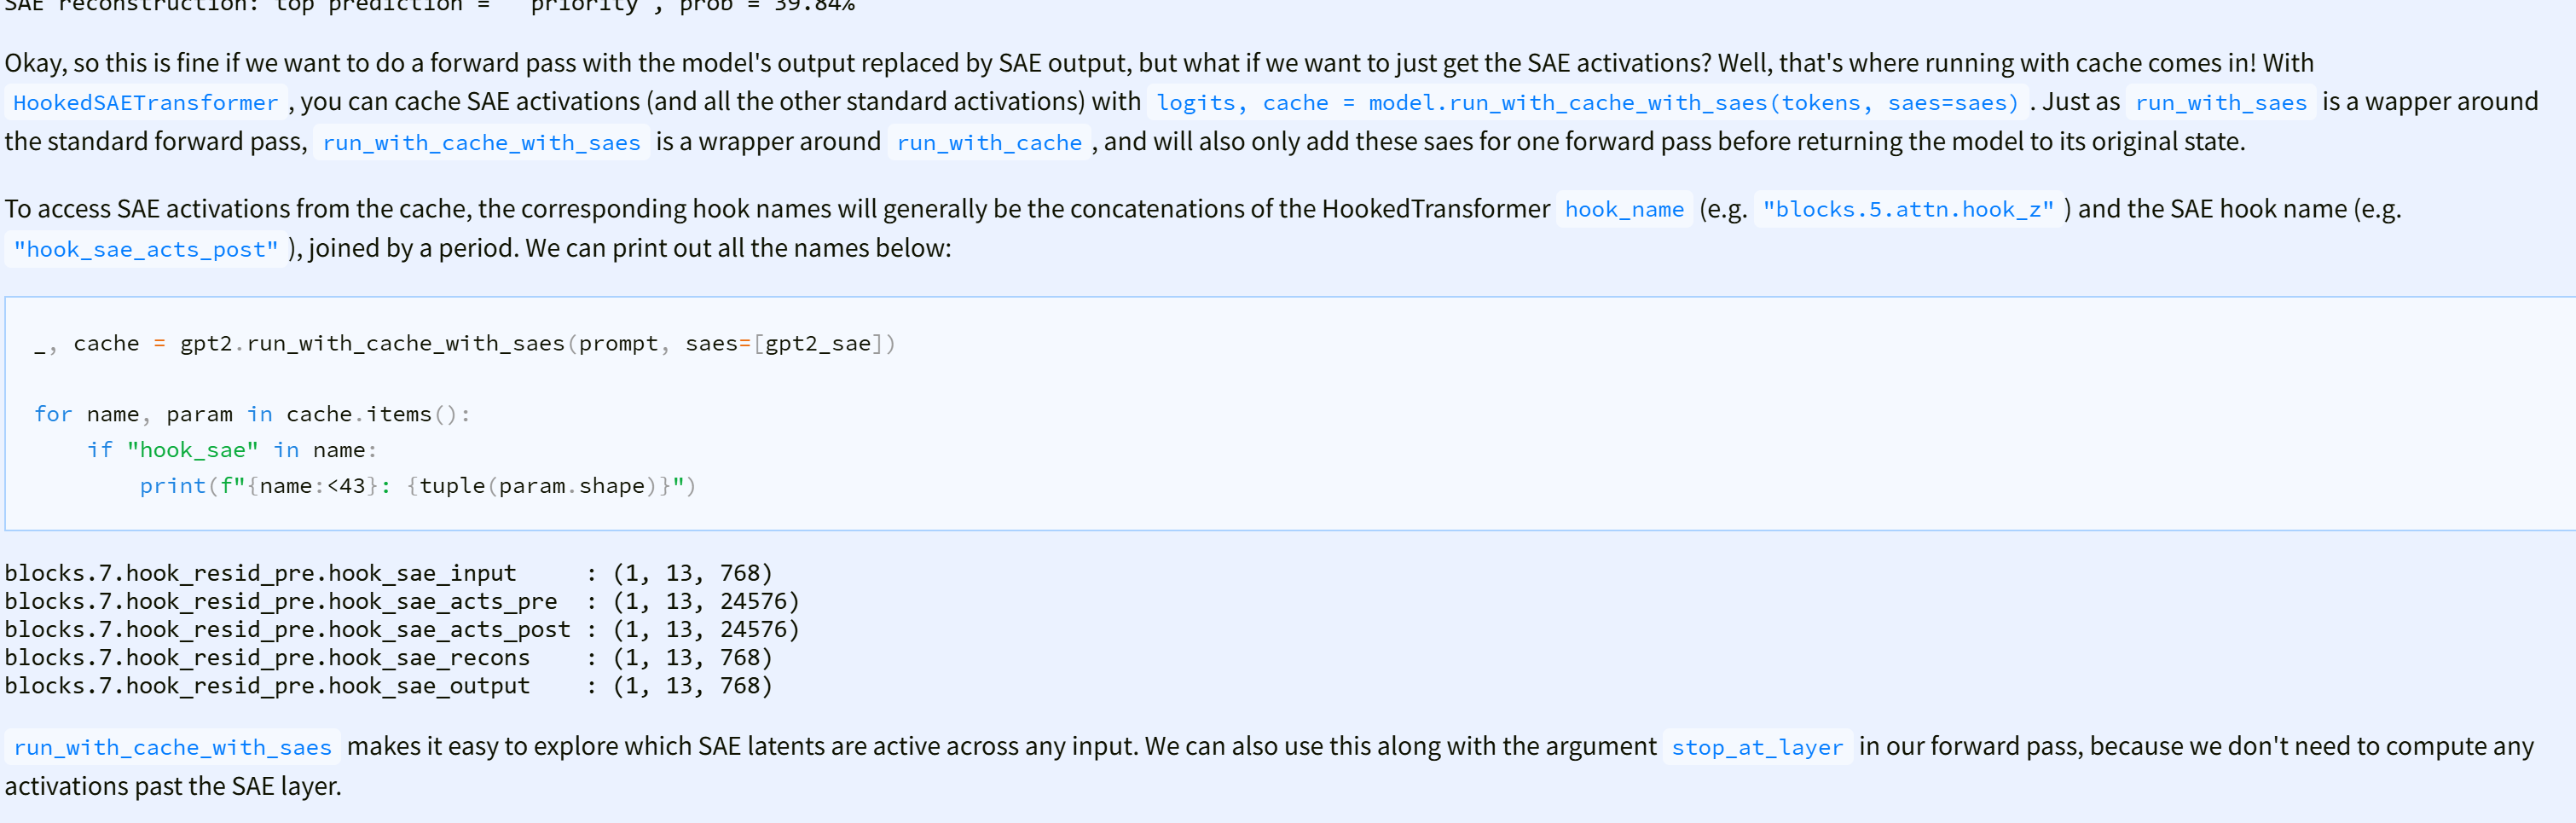

In [20]:
#from tutorial.. only get part of the cache!
"""# Get top activations on final token
_, cache = gpt2.run_with_cache_with_saes(
    prompt,
    saes=[gpt2_sae],
    stop_at_layer=gpt2_sae.cfg.hook_layer + 1,
)
sae_acts_post = cache[f"{gpt2_sae.cfg.hook_name}.hook_sae_acts_post"][0, -1, :]
"""

'# Get top activations on final token\n_, cache = gpt2.run_with_cache_with_saes(\n    prompt,\n    saes=[gpt2_sae],\n    stop_at_layer=gpt2_sae.cfg.hook_layer + 1,\n)\nsae_acts_post = cache[f"{gpt2_sae.cfg.hook_name}.hook_sae_acts_post"][0, -1, :]\n'

In [21]:
"""def generate_with_steering_and_reduced_cache(
    model: HookedSAETransformer,
    sae: SAE,
    prompt: str,
    latent_idx: int,
    steering_coefficient: float = 1.0,
    max_new_tokens: int = 50,
):
"""
    #Generates text with steering and returns both the output text and SAE activations.
    #Returns a tuple of (generated_text, sae_acts) containing the generated text and
    #the SAE activations for the sequence.
"""
    _steering_hook = partial(
        steering_hook,
        sae=sae,
        latent_idx=latent_idx,
        steering_coefficient=steering_coefficient,
    )
    
    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, _steering_hook)]):
        # Generate text
        tokens = model.to_tokens(prompt)
        logits, cache = model.run_with_cache(
            tokens,
            stop_at_layer=sae.cfg.hook_layer + 1,
            #max_new_tokens=max_new_tokens,
            **GENERATE_KWARGS
        )
        
        
        # Get SAE activations for final token
        sae_acts = sae.encode(cache[sae.cfg.hook_name][:, -1, :])
        
        # Convert tokens to text
        output_text = model.to_string(tokens)
    
    return output_text, sae_acts"""

'\n    _steering_hook = partial(\n        steering_hook,\n        sae=sae,\n        latent_idx=latent_idx,\n        steering_coefficient=steering_coefficient,\n    )\n    \n    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, _steering_hook)]):\n        # Generate text\n        tokens = model.to_tokens(prompt)\n        logits, cache = model.run_with_cache(\n            tokens,\n            stop_at_layer=sae.cfg.hook_layer + 1,\n            #max_new_tokens=max_new_tokens,\n            **GENERATE_KWARGS\n        )\n        \n        \n        # Get SAE activations for final token\n        sae_acts = sae.encode(cache[sae.cfg.hook_name][:, -1, :])\n        \n        # Convert tokens to text\n        output_text = model.to_string(tokens)\n    \n    return output_text, sae_acts'

In [22]:
def generate_with_steering_and_reduced_cache(
    model: HookedSAETransformer,
    sae: SAE,
    prompt: str,
    latent_idx: int,
    steering_coefficient: float = 1.0,
    max_new_tokens: int = 50,
):
    """
    Generates text with steering and returns both the output text and SAE activations.
    """
    _steering_hook = partial(
        steering_hook,
        sae=sae,
        latent_idx=latent_idx,
        steering_coefficient=steering_coefficient,
    )
    
    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, _steering_hook)]):
        # Generate text - clone the tokens to avoid inference mode issues
        tokens = model.to_tokens(prompt).clone()
        
        # Generate with the cloned tokens
        tokens = model.generate(
            tokens,
            max_new_tokens=max_new_tokens,
            **GENERATE_KWARGS
        )
        # Convert tokens to text
        output_text = model.to_string(tokens)

        
        # Get cache for final state
        _, cache = model.run_with_cache(
            tokens.clone(),  # Clone again for the cache run
            stop_at_layer=sae.cfg.hook_layer + 1
        )
        
        # Get SAE activations for final token
        sae_acts = sae.encode(cache[sae.cfg.hook_name][:, -1, :])
        
        
    
    return output_text, sae_acts

In [23]:
def get_top_latents(sae_acts, k=10):
    # Remove batch dimension if present
    if len(sae_acts.shape) > 1:
        sae_acts = sae_acts[0]  # Take first batch element
    
    # Get top k latents and their activations
    values, indices = t.topk(sae_acts, k)
    
    # Format as list of (index, value) tuples
    return [(int(idx.item()), float(val.item())) for idx, val in zip(indices, values)]

In [24]:
prompt = "When I look at myself in the mirror, I see"

no_steering_output, sae_acts = generate_with_steering_and_reduced_cache(
    gemma_2_2b,
    gemma_2_2b_sae,
    prompt,
    latent_idx,
    steering_coefficient=1
)
sae_acts_list_cpu = []
sae_acts_list_cpu.append(sae_acts.cpu())

table = Table(show_header=False, show_lines=True, title="Steering Output")
# Convert the list to a formatted string
top_latents = get_top_latents(sae_acts)
top_latents_str = "Top latents: " + ", ".join([f"({idx}, {val:.2f})" for idx, val in top_latents])
# Convert output_text to string if it's a list
output_str = " ".join(no_steering_output) if isinstance(no_steering_output, list) else str(no_steering_output)
table.add_row("Normal", output_str, top_latents_str)

t.cuda.empty_cache()

for i in tqdm(range(3), "Generating steered examples..."):
    output_text, sae_acts = generate_with_steering_and_reduced_cache(
        gemma_2_2b,
        gemma_2_2b_sae,
        prompt,
        latent_idx,
        steering_coefficient=240.0
    )
    
    # Format top latents as a nicely formatted string
    top_latents = get_top_latents(sae_acts)
    top_latents_str = "Top latents: " + ", ".join([f"({idx}, {val:.2f})" for idx, val in top_latents])
    
    # Convert output_text to string if it's a list
    output_str = " ".join(output_text) if isinstance(output_text, list) else str(output_text)
    output_str = output_str.replace("\n", "↵")
    
    table.add_row(
        f"Steered #{i}",
        output_str,
        top_latents_str
    )   
        
    sae_acts_list_cpu.append(sae_acts.cpu())
    del sae_acts
    t.cuda.empty_cache()
    
rprint(table)

Generating steered examples...:   0%|          | 0/3 [00:00<?, ?it/s]

                                                  Steering Output                                                  
┌────────────┬─────────────────────────────────────────────────┬──────────────────────────────────────────────────┐
│ Normal     │ <bos>When I look at myself in the mirror, I see │ Top latents: (11571, 137.89), (11135, 55.37),    │
│            │ a woman with a lot of confidence. Don’t get me  │ (11133, 52.44), (11612, 40.19), (2257, 33.91),   │
│            │ wrong, there are days that I doubt myself and   │ (7469, 30.04), (9768, 30.03), (13308, 20.62),    │
│            │ think that my life has no meaning but when it   │ (9226, 20.37), (411, 18.37)                      │
│            │ comes to what I do for work, there is no doubt  │                                                  │
│            │ in my mind that what                            │                                                  │
├────────────┼─────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ Steered #0 │ <bos>When I look at myself in the mirror, I see │ Top latents: (12082, 264.19), (1858, 103.15),    │
│            │ a woman that is full of love and loyalty. My    │ (1089, 51.30), (6631, 44.83), (2468, 40.46),     │
│            │ life has been filled with love and loyalty. We  │ (13747, 39.74), (2229, 34.87), (15848, 33.56),   │
│            │ are all born with this breed of love. It is a   │ (6769, 33.53), (5931, 30.93)                     │
│            │ breed that will never be fully understood by    │                                                  │
│            │ any other dog or even another human being.      │                                                  │
├────────────┼─────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ Steered #1 │ <bos>When I look at myself in the mirror, I see │ Top latents: (12082, 211.55), (9747, 80.58),     │
│            │ a woman who is always on the go. She is busy    │ (7449, 80.22), (12261, 59.14), (12267, 57.52),   │
│            │ with her work, her family and her friends. She  │ (6631, 43.43), (8573, 34.70), (3997, 32.39),     │
│            │ loves to travel and meet new people, but        │ (2219, 30.91), (2468, 30.22)                     │
│            │ sometimes she feels like she doesn’t have       │                                                  │
│            │ enough time for herself.↵↵I want to             │                                                  │
├────────────┼─────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ Steered #2 │ <bos>When I look at myself in the mirror, I see │ Top latents: (12082, 244.79), (9850, 73.99),     │
│            │ a woman who is full of energy and love. She has │ (8573, 53.25), (1621, 53.09), (3690, 51.59),     │
│            │ a beautiful smile that is always ready to wag   │ (11612, 47.80), (4183, 45.14), (11572, 42.10),   │
│            │ her tail. She loves to play with her toys and   │ (7150, 39.15), (2468, 37.54)                     │
│            │ fetch the ball. Her favorite treat is peanut    │                                                  │
│            │ butter, and she loves to snuggle up             │                                                  │
└────────────┴─────────────────────────────────────────────────┴──────────────────────────────────────────────────┘

In [25]:
no_steering_output

['<bos>When I look at myself in the mirror, I see a woman with a lot of confidence. Don’t get me wrong, there are days that I doubt myself and think that my life has no meaning but when it comes to what I do for work, there is no doubt in my mind that what']

random seed 42, temp 0, penalty 0 normal output: ['<bos>When I look at myself in the mirror, I see a woman who is strong, independent, and confident. I am a mother of two beautiful children, a wife, a daughter, a sister, and a friend. I am a woman who has overcome many challenges in life and has learned to be resilient']


In [26]:
output_text

['<bos>When I look at myself in the mirror, I see a woman who is full of energy and love. She has a beautiful smile that is always ready to wag her tail. She loves to play with her toys and fetch the ball. Her favorite treat is peanut butter, and she loves to snuggle up']

In [27]:

fig = px.line(
    title="Latent activations at final token positions", 
    labels={"index": "Latent", "value": "Activation"},
    width=1000,
)

for i, sae_acts in enumerate(sae_acts_list_cpu):
    # Ensure we're working with a 1D tensor by squeezing any extra dimensions
    acts_1d = sae_acts.squeeze()
    fig.add_scatter(
        y=acts_1d.detach().numpy(),
        name=f"Generation {i}",
        mode='lines'
    )

fig.update_layout(showlegend=True).show()

# Print the top 3 latents for each generation and inspect their dashboards
for i, sae_acts in enumerate(sae_acts_list_cpu):
    print(f"\nGeneration {i} top latents:")
    # Ensure we're working with a 1D tensor
    acts_1d = sae_acts.squeeze()
    values, indices = acts_1d.topk(3)
    
    for val, idx in zip(values, indices):
        print(f"Latent {idx.item()} had activation {val.item():.2f}")
        display_dashboard(
            sae_release=gemmascope_sae_release,
            sae_id=gemmascope_sae_id,
            latent_idx=idx.item()
        )


Generation 0 top latents:
Latent 11571 had activation 137.89
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/11571?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 11135 had activation 55.37
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/11135?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 11133 had activation 52.44
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/11133?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300



Generation 1 top latents:
Latent 12082 had activation 264.19
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/12082?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 1858 had activation 103.15
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/1858?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 1089 had activation 51.30
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/1089?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300



Generation 2 top latents:
Latent 12082 had activation 211.55
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/12082?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 9747 had activation 80.58
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/9747?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 7449 had activation 80.22
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/7449?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300



Generation 3 top latents:
Latent 12082 had activation 244.79
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/12082?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 9850 had activation 73.99
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/9850?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 8573 had activation 53.25
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/8573?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [28]:
""""# Plot line chart of latent activations
import plotly.express as px
fig = px.line(
    title="Latent activations at final token positions", 
    labels={"index": "Latent", "value": "Activation"},
    width=1000,
)

for i, sae_acts in enumerate(sae_acts_list_cpu):
    fig.add_scatter(
        y=sae_acts.detach().numpy(),
        name=f"Generation {i}",
        mode='lines'
    )

fig.update_layout(showlegend=True).show()

# Print the top 3 latents for each generation and inspect their dashboards
for i, sae_acts in enumerate(sae_acts_list_cpu):
    print(f"\nGeneration {i} top latents:")
    for act, ind in zip(*sae_acts.detach().topk(3)):
        print(f"Latent {ind} had activation {act.item():.2f}")
        display_dashboard(latent_idx=ind)"""

'"# Plot line chart of latent activations\nimport plotly.express as px\nfig = px.line(\n    title="Latent activations at final token positions", \n    labels={"index": "Latent", "value": "Activation"},\n    width=1000,\n)\n\nfor i, sae_acts in enumerate(sae_acts_list_cpu):\n    fig.add_scatter(\n        y=sae_acts.detach().numpy(),\n        name=f"Generation {i}",\n        mode=\'lines\'\n    )\n\nfig.update_layout(showlegend=True).show()\n\n# Print the top 3 latents for each generation and inspect their dashboards\nfor i, sae_acts in enumerate(sae_acts_list_cpu):\n    print(f"\nGeneration {i} top latents:")\n    for act, ind in zip(*sae_acts.detach().topk(3)):\n        print(f"Latent {ind} had activation {act.item():.2f}")\n        display_dashboard(latent_idx=ind)'

# Find max activation strength before amplifying it..: 

MEMORY may be an issue here -- see new implementation below. Takes quite long as it uses several prompts. It may be easier to just look at neuropedia & see the max activating examples..

Original Code is from::
https://github.com/jbloomAus/SAELens/blob/main/tutorials/tutorial_2_0.ipynb

In [29]:


# a convenient way to instantiate an activation store is to use the from_sae method
activation_store = ActivationsStore.from_sae(
    model=gemma_2_2b,  # TODO: make generic during set-up
    sae=gemma_2_2b_sae, # TODO: make generic during set-up
    streaming=True,
    # fairly conservative parameters here so can use same for larger
    # models without running out of memory.
    store_batch_size_prompts=8,
    train_batch_size_tokens=4096,
    n_batches_in_buffer=32,
    device=device,
)
"""
def find_max_activation(model, sae, activation_store, feature_idx, num_batches=100):

#Find the maximum activation for a given feature index. This is useful for
#calibrating the right amount of the feature to add.

    max_activation = 0.0

    pbar = tqdm(range(num_batches))
    for _ in pbar:
        tokens = activation_store.get_batch_tokens()

        _, cache = model.run_with_cache(
            tokens,
            stop_at_layer=sae.cfg.hook_layer + 1,
            names_filter=[sae.cfg.hook_name],
        )
        sae_in = cache[sae.cfg.hook_name]
        feature_acts = sae.encode(sae_in).squeeze()

        feature_acts = feature_acts.flatten(0, 1)
        batch_max_activation = feature_acts[:, feature_idx].max().item()
        max_activation = max(max_activation, batch_max_activation)

        pbar.set_description(f"Max activation: {max_activation:.4f}")

    return max_activation"""
    # Less momry heavy version:
def find_max_activation(model, sae, activation_store, feature_idx, num_batches=100):
    """
    Find the maximum activation for a given feature index with optimized memory usage.
    """
    max_activation = 0.0

    # Use smaller batch size for activation store
    activation_store.store_batch_size_prompts = 4  # Reduced from 8
    activation_store.train_batch_size_tokens = 2048  # Reduced from 4096

    pbar = tqdm(range(num_batches))
    with t.no_grad():  # Disable gradient computation
        for _ in pbar:
            try:
                tokens = activation_store.get_batch_tokens()

                # Run with cache using minimal memory
                _, cache = model.run_with_cache(
                    tokens,
                    stop_at_layer=sae.cfg.hook_layer + 1,
                    names_filter=[sae.cfg.hook_name],
                )
                
                # Process in smaller chunks if needed
                sae_in = cache[sae.cfg.hook_name]
                chunk_size = 32  # Adjust based on your GPU memory
                for i in range(0, sae_in.shape[0], chunk_size):
                    chunk = sae_in[i:i + chunk_size]
                    feature_acts = sae.encode(chunk).squeeze()
                    feature_acts = feature_acts.flatten(0, 1)
                    
                    # Move to CPU for max calculation
                    batch_max = feature_acts[:, feature_idx].cpu().max().item()
                    max_activation = max(max_activation, batch_max)

                # Clear cache after processing
                del cache, sae_in, feature_acts
                t.cuda.empty_cache()

                pbar.set_description(f"Max activation: {max_activation:.4f}")
                
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print("WARNING: GPU OOM, clearing cache and trying again...")
                    if 'cache' in locals():
                        del cache
                    if 'sae_in' in locals():
                        del sae_in
                    if 'feature_acts' in locals():
                        del feature_acts
                        t.cuda.empty_cache()
                        continue
                    else:
                        raise e
    return max_activation

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\Maximus\.conda\envs\lets_drift_env_V1\Lib\site-packages\sae_lens\training\activations_store.py:285: UserWarning:

Dataset is not tokenized. Pre-tokenizing will improve performance and allows for more control over special tokens. See https://jbloomaus.github.io/SAELens/training_saes/#pretokenizing-datasets for more info.



In [30]:
max_activation = find_max_activation(
    gemma_2_2b,
    gemma_2_2b_sae,
    activation_store,
    latent_idx,
    num_batches=100
)
print(f"Maximum activation found: {max_activation:.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Maximum activation found: 53.25


Above code seems to work, gives out:

 Max activation: 53.2513: 100%
 100/100 [40:31<00:00, 24.34s/it]
Maximum activation found: 53.25

took 40 min!